In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable

n = 30
train_x = torch.zeros(int(pow(n, 2)), 2)
train_y = torch.zeros(int(pow(n, 2)))
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n - 1)
        train_x[i * n + j][1] = float(j) / (n - 1)
        train_y[i * n + j] = pow(-1, int(3 * i / n + int(3 * j / n)))
train_x = Variable(train_x)
train_y = Variable(train_y)

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class GPClassificationModel(gpytorch.GPModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
        self.grid_covar_module = GridInterpolationKernel(self.covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-6,6))
        self.initialize_interpolation_grid(10, [(0, 1), (0, 1)])
    
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

model = GPClassificationModel()
model.condition(train_x, train_y)

/home/jrg365/anaconda2/lib/python2.7/site-packages/torch/autograd/_functions/basic_ops.py:48: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return a.mul(b)


GPClassificationModel (
  (likelihood): BernoulliLikelihood (
  )
  (mean_module): ConstantMean (
  )
  (covar_module): RBFKernel (
  )
  (grid_covar_module): GridInterpolationKernel (
    (base_kernel_module): RBFKernel (
    )
  )
)

In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    n = 100
    test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
    for i in range(n):
        for j in range(n):
            test_x.data[i * n + j][0] = float(i) / (n-1)
            test_x.data[i * n + j][1] = float(j) / (n-1)
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1).data.numpy()
        color = []
        for i in range(len(pred_labels)):
            if pred_labels[i] == 1:
                color.append('y')
            else:
                color.append('r')
        ax.scatter(test_x.data[:, 0].numpy(), test_x.data[:, 1].numpy(), color=color, s=1)
        ax.set_ylim([-0.5, 1.5])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Predicted Values')
    
    return f

In [6]:
# Find optimal model hyperparameters
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.2)
optimizer.n_iter = 0
for i in range(200):
    optimizer.zero_grad()
    output = model.forward(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/200 - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, loss.data[0],
        model.covar_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()
    
# Set back to eval mode
model.eval()

/mnt/c/Users/Gardn/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/200 - Loss: 311599.500   log_lengthscale: 0.000
Iter 2/200 - Loss: 55363.918   log_lengthscale: -0.200
Iter 3/200 - Loss: 18659.123   log_lengthscale: -0.399
Iter 4/200 - Loss: 17940.912   log_lengthscale: -0.559
Iter 5/200 - Loss: 16955.541   log_lengthscale: -0.722
Iter 6/200 - Loss: 23207.457   log_lengthscale: -0.883
Iter 7/200 - Loss: 17786.529   log_lengthscale: -1.049
Iter 8/200 - Loss: 11628.727   log_lengthscale: -1.205
Iter 9/200 - Loss: 14009.729   log_lengthscale: -1.354
Iter 10/200 - Loss: 12302.094   log_lengthscale: -1.495
Iter 11/200 - Loss: 8684.758   log_lengthscale: -1.635
Iter 12/200 - Loss: 6835.046   log_lengthscale: -1.763
Iter 13/200 - Loss: 5477.286   log_lengthscale: -1.881
Iter 14/200 - Loss: 4269.910   log_lengthscale: -1.990
Iter 15/200 - Loss: 5671.488   log_lengthscale: -2.093
Iter 16/200 - Loss: 4746.941   log_lengthscale: -2.188
Iter 17/200 - Loss: 4862.853   log_lengthscale: -2.277
Iter 18/200 - Loss: 4775.110   log_lengthscale: -2.361
Iter 19/2

Iter 151/200 - Loss: 409.530   log_lengthscale: -3.799
Iter 152/200 - Loss: 364.249   log_lengthscale: -3.799
Iter 153/200 - Loss: 341.714   log_lengthscale: -3.799
Iter 154/200 - Loss: 372.854   log_lengthscale: -3.800
Iter 155/200 - Loss: 352.827   log_lengthscale: -3.800
Iter 156/200 - Loss: 351.261   log_lengthscale: -3.800
Iter 157/200 - Loss: 331.005   log_lengthscale: -3.800
Iter 158/200 - Loss: 349.649   log_lengthscale: -3.800
Iter 159/200 - Loss: 371.038   log_lengthscale: -3.801
Iter 160/200 - Loss: 344.388   log_lengthscale: -3.801
Iter 161/200 - Loss: 337.044   log_lengthscale: -3.801
Iter 162/200 - Loss: 339.296   log_lengthscale: -3.801
Iter 163/200 - Loss: 342.523   log_lengthscale: -3.802
Iter 164/200 - Loss: 382.012   log_lengthscale: -3.802
Iter 165/200 - Loss: 361.941   log_lengthscale: -3.802
Iter 166/200 - Loss: 364.341   log_lengthscale: -3.802
Iter 167/200 - Loss: 360.845   log_lengthscale: -3.803
Iter 168/200 - Loss: 350.015   log_lengthscale: -3.803
Iter 169/2

GPClassificationModel (
  (likelihood): BernoulliLikelihood (
  )
  (mean_module): ConstantMean (
  )
  (covar_module): RBFKernel (
  )
  (grid_covar_module): GridInterpolationKernel (
    (base_kernel_module): RBFKernel (
    )
  )
)

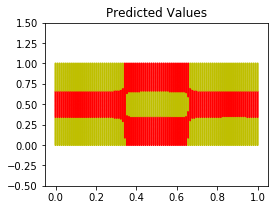

In [8]:
f = plot_model_and_predictions(model)